In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import warnings
import math

from scipy import stats
from tempfile import mkdtemp
from shutil import rmtree

from xgboost import XGBRegressor, XGBClassifier

from sklearn import set_config
set_config(display = 'diagram')
# Sklearn preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor,\
                            RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error, r2_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.cluster import KMeans

In [2]:
users_df = pd.read_csv('../raw_data/users.csv')
centers_df = pd.read_csv('../raw_data/distribution_centers.csv')
events_df = pd.read_csv('../raw_data/events.csv')
inventory_items_df = pd.read_csv('../raw_data/inventory_items.csv')
order_items_df = pd.read_csv('../raw_data/order_items.csv')
orders_df = pd.read_csv('../raw_data/orders.csv')
products_df = pd.read_csv('../raw_data/products.csv')

# Data Exploration

In [3]:
def dtype_cast_datetime(df):    
    # datetime format cast
    dt_columns = [col for col in df.columns if col.endswith('_at')]

    for column in dt_columns:
        df[column] = pd.to_datetime(df[column], errors='coerce',
                                    infer_datetime_format=True).dt.tz_localize(None)
        
#         pd.to_datetime(orders_df[column],format='mixed').dt.tz_localize(None)

    return df


In [4]:
def join_tables_item_level(order_items_df, products_df):
    '''
    Joins order-item & product
    '''
    order_items_df = dtype_cast_datetime(order_items_df) # datetime cast
    
    order_items_df = order_items_df[['id', 
                                     'order_id', 
                                     'user_id', 
                                     'product_id', 
                                     'inventory_item_id',
                                     'status', 
                                     'created_at', 
                                     # 'shipped_at', 
                                     # 'delivered_at', 
                                     # 'returned_at',
                                     'sale_price']].rename(columns={'id':'order_item_id','status':'order_status'})    
    
    products_df = products_df[['id', 
                               'cost', 
                               'category', 
                               'name',
                               'brand',
                               'retail_price', 
                               'department',
                               # 'sku',
                               'distribution_center_id']]

    
    df_joined = order_items_df.merge(products_df, left_on='product_id', right_on='id', how='left')
    df_joined = df_joined.drop(columns=['id']) # duplicate product id    

    return df_joined

In [5]:
item_level_df = join_tables_item_level(order_items_df, products_df)

## Data Exploration

In [6]:
# # Check users
# users_df_test = users_df.copy()
# users_df_test['created_at'] = pd.to_datetime(users_df_test['created_at'],format='mixed').dt.tz_localize(None)
# users_df_test.hist('created_at')

In [7]:
# # Check order trend
# orders_test = orders_df.copy()
# orders_test['created_at'] = pd.to_datetime(orders_test['created_at'],format='mixed').dt.tz_localize(None)
# orders_test.hist('created_at')

In [8]:
# orders_cnt = orders_test.groupby(by='user_id')['order_id'].count().reset_index(name='orders')

# orders_cnt['orders'].hist()

# # Most of users only buy once

In [9]:
# users_test = orders_df.copy()
# users_test['created_at'] = pd.to_datetime(users_test['created_at'],format='mixed').dt.tz_localize(None)

In [10]:
# users_test['year'] = users_test.created_at.dt.year

#### ? Users sign up early and buy later somehow

In [11]:
# orders_w_user = orders_test.merge(users_test[['user_id','created_at']].rename(columns={'created_at':'user_created_at'}), on='user_id')

In [12]:
# orders_w_user['months_from_signup'] = (orders_w_user.created_at-orders_w_user.user_created_at).dt.days/30

In [13]:
# orders_w_user.months_from_signup.hist()

# user_created_at is wrong

In [14]:
orders_df.columns

Index(['order_id', 'user_id', 'status', 'gender', 'created_at', 'returned_at',
       'shipped_at', 'delivered_at', 'num_of_item'],
      dtype='object')

#### ? Is there brands working bad in terms of return rate?

In [15]:
# item_product_df = join_tables_item_level(order_items_df, products_df)

In [16]:
# item_product_df['num_returns'] = item_product_df.

In [17]:
# item_product_df.groupby(by=['brand','order_status'])['order_id'].nunique().reset_index()

# Data Prep Functions

In [18]:
orders_df.columns

Index(['order_id', 'user_id', 'status', 'gender', 'created_at', 'returned_at',
       'shipped_at', 'delivered_at', 'num_of_item'],
      dtype='object')

## Order table prep

In [340]:
def restructure_orders_prev_next(df):
    '''
    ---
    '''
    orders_df = dtype_cast_datetime(df).copy()
    # order ranks
    orders_df['order_rank'] = orders_df.groupby('user_id')['created_at'].rank(method='first').astype(int)
    orders_df = orders_df.sort_values(by=['user_id', 'created_at'])

    max_date = orders_df['created_at'].max() ## to calculate days left to predict

    # Calc delivery day
    orders_df['delivery_days'] = (orders_df['delivered_at'] - orders_df['created_at']).dt.days
    # Calc shipped day
    orders_df['delivery_days'] = (orders_df['shipped_at'] - orders_df['created_at']).dt.days

    # weekday
    orders_df['weekday_ordered'] = orders_df['created_at'].dt.dayofweek
    orders_df['weekday_delivered'] = orders_df['delivered_at'].dt.dayofweek

    # counts other status
    orders_df['returned?'] = orders_df['returned_at'].apply(lambda x : 1 if pd.notna(x) else 0)
    orders_df['shipped?'] = orders_df['shipped_at'].apply(lambda x : 1 if pd.notna(x) else 0)
    orders_df['delivered?'] = orders_df['delivered_at'].apply(lambda x : 1 if pd.notna(x) else 0)

    orders_df['return_cumsum'] = orders_df.groupby(by='user_id')['returned?'].cumsum()
    orders_df['ship_cumsum'] = orders_df.groupby(by='user_id')['shipped?'].cumsum()
    orders_df['deliver_cumsum'] = orders_df.groupby(by='user_id')['delivered?'].cumsum()
    
    # User-level T
    orders_df['min_order_created_at'] = orders_df.groupby(by='user_id')['created_at'].transform('min')
    orders_df['min_order_delivered_at'] = orders_df.groupby(by='user_id')['delivered_at'].transform('min')

    orders_df['customer_T'] = (orders_df['created_at']-orders_df['min_order_created_at']).dt.days
    orders_df['days_from_first_delivery'] = (orders_df['created_at']-orders_df['min_order_delivered_at']).dt.days
    orders_df['days_from_first_delivery'] = orders_df['days_from_first_delivery'].apply(lambda x : x if x >= 0 else np.nan)
    
    orders_df['days_left_to_predict'] = (max_date- orders_df['created_at']).dt.days
    
    # Total items
    orders_df['items_until_now'] = orders_df.groupby(by='user_id')['num_of_item'].cumsum()
    orders_df['num_items_delivered'] = orders_df.apply(lambda row: row['num_of_item'] if row['delivered?']==1 else 0, axis=1)
    orders_df['delivered_items_until_now'] = orders_df.groupby(by='user_id')['num_items_delivered'].cumsum()

    # avg days between orders
    orders_df['avg_days_btw_orders'] = orders_df['customer_T']/orders_df['order_rank']
    
    # Next orders
    orders_next = orders_df.copy()
    orders_next['order_rank_prev'] = orders_next['order_rank']-1
    orders_next = orders_next[['user_id','order_id','order_rank_prev','created_at']].rename(columns={'order_id':'next_order_id',
                                                                                                     'created_at':'next_order_created_at'})
    
    orders_prev_next = orders_df.merge(orders_next, left_on=['user_id','order_rank'], right_on=['user_id','order_rank_prev'], how='left')

    
    orders_prev_next['days_until_next_order'] = (orders_prev_next.next_order_created_at - orders_prev_next.created_at).dt.days
    orders_prev_next['days_until_next_order_group'] = orders_prev_next['days_until_next_order']//50
    
    orders_prev_next['next_order?'] = orders_prev_next['next_order_id'].notna()

    return orders_prev_next.drop(columns='order_rank_prev')

In [288]:
test = restructure_orders_prev_next(orders_df)

,order_id,user_id,days_until_next_order
0,1,1,NaN
1,2,2,NaN
2,5,3,23.0
3,6,3,21.0
4,3,3,107.0
5,4,3,NaN
6,7,4,NaN
7,8,5,NaN
8,9,6,NaN
9,10,7,NaN


''

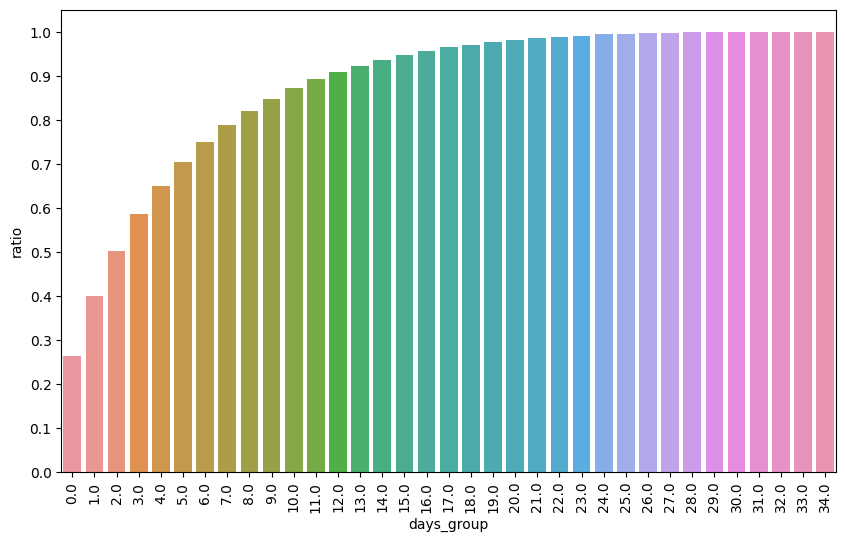

In [339]:
data_test = test[['order_id','user_id','order_rank','days_until_next_order']]
data_test['days_group'] = (data_test.days_until_next_order//50)

data_test_g = data_test.groupby(['days_group','order_rank'])['order_id'].nunique().reset_index(name='orders')
# sns.scatterplot(data=data_test_g, x='days_group', y='order_id', hue='order_rank');


data_test_g2 = data_test.groupby('days_group')['order_id'].nunique().reset_index(name='orders').sort_values('days_group')
data_test_g2['runsum'] = data_test_g2['orders'].cumsum()
total_orders = data_test_g2.orders.sum()
data_test_g2['ratio'] =  data_test_g2['runsum']/total_orders

data_test_g2

plt.figure(figsize=(10,6))
sns.barplot(data=data_test_g2,x='days_group',y='ratio')
plt.xticks(rotation=90)
plt.yticks([i/10 for i in range(11)])
;

# next 600 days are our y

In [238]:
# test[test.weekday_delivered == 6][['weekday_delivered','delivered_at']]

In [21]:
test[test['user_id'].isin([99983,44])][['order_id','user_id','created_at','order_rank','min_order_created_at','return_cumsum']]

,order_id,user_id,created_at,order_rank,min_order_created_at,return_cumsum
58,60,44,2023-01-20 02:12:00,1,2023-01-20 02:12:00,0
59,59,44,2023-09-11 02:12:00,2,2023-01-20 02:12:00,0
125207,125208,99983,2022-03-14 15:06:00,1,2022-03-14 15:06:00,0
125208,125209,99983,2022-09-07 15:06:00,2,2022-03-14 15:06:00,0
125209,125210,99983,2023-03-01 15:06:00,3,2022-03-14 15:06:00,0
125210,125211,99983,2023-08-25 15:06:00,4,2022-03-14 15:06:00,0


## distance calculation

In [22]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the Earth's surface given their latitude and longitude
    in decimal degrees.
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371  # Radius of Earth in kilometers. Use 3956 for miles
    return c * r

In [23]:
def calc_distance(products_df, centers_df, users_df, order_items_df):
    prod_center_df = products_df[['id','distribution_center_id']].merge(centers_df[['id','latitude','longitude']], 
                                                                        left_on='distribution_center_id', 
                                                                        right_on='id', how='left')\
                                                                .rename(
                                                                    columns={'id_x':'product_id',
                                                                             'latitude':'prod_lat',
                                                                             'longitude':'prod_lon'}).drop(columns='id_y')
    
    
    order_user_df = order_items_df[['order_id','user_id','product_id']].merge(users_df[['id','latitude','longitude']]
                                                                              , left_on= 'product_id', right_on = 'id', how='left')\
                                                                              .drop(columns='id') \
                                                                              .rename(columns={
                                                                                  'latitude':'user_lat',
                                                                                  'longitude':'user_lon'
                                                                              })
    
    distance_df = order_user_df.merge(prod_center_df, on='product_id', how='left')

    # Assuming df has columns 'lat1', 'lon1', 'lat2', 'lon2'
    distance_df['distance'] = distance_df.apply(lambda row: haversine(row['prod_lat'], row['prod_lon'], row['user_lat'], row['user_lon']), axis=1)

    result = distance_df.groupby(by='order_id')['distance'].mean().reset_index(name='avg_distance')

    return result



In [24]:
calc_distance(products_df, centers_df, users_df, order_items_df)

,order_id,avg_distance
0,1,12169.291372
1,2,10981.424735
2,3,7551.181495
3,4,9183.548783
4,5,6668.954200
...,...,...
125221,125222,12457.922574
125222,125223,6889.798937
125223,125224,9422.287851
125224,125225,7259.330858


## Product level calculation

In [25]:
def product_info(item_level_df):
    '''
    takes item-level dataframe and calculate features to user level.
    '''

    base = item_level_df[['order_id','order_item_id']].groupby('order_id').count().fillna(0).rename(columns={'order_item_id':'num_order_item'}).reset_index()

    # order revenue
    revenue = item_level_df.groupby(by='order_id')['sale_price'].sum().reset_index(name='sale_price')
    base = base.merge(revenue, on='order_id', how='left') 
    
    # order retail_price
    revenue = item_level_df.groupby(by='order_id')['retail_price'].sum().reset_index(name='retail_price')
    base = base.merge(revenue, on='order_id', how='left') 
    
    
    # Most frequent category
    count_cat = item_level_df.groupby(['order_id', 'category']).size().reset_index(name='count')
    # Find the index of the row with the maximum count for each user
    max_count_index = count_cat.groupby('order_id')['count'].idxmax()
    # Extract the rows corresponding to the maximum counts
    preferred_categories = count_cat.loc[max_count_index]
    # remove duplicates
    pref_cat_no_duplicates = preferred_categories.drop_duplicates(subset=['order_id']).rename(columns={'category':'category_preffered'})

    base = base.merge(pref_cat_no_duplicates[['order_id','category_preffered']],on='order_id',how='left')            


    # Department
    # Most frequent category
    count_dept = item_level_df.groupby(['order_id', 'department']).size().reset_index(name='count')
    # Find the index of the row with the maximum count for each user
    max_count_index_dept = count_dept.groupby('order_id')['count'].idxmax()
    # Extract the rows corresponding to the maximum counts
    preferred_dept = count_dept.loc[max_count_index_dept]
    # remove duplicates
    pref_dept_no_duplicates = preferred_dept.drop_duplicates(subset=['order_id']).rename(columns={'department':'dept_pref'})

    base = base.merge(pref_dept_no_duplicates[['order_id','dept_pref']],on='order_id',how='left')    
    
    return base

## User dataset

In [26]:
def select_user_columns(users_df):

    df = users_df[['id','age','country','created_at','traffic_source']].rename(columns={'id':'user_id','created_at':'user_created_at'})
    # Filter users only for last 2 years from split date
    # min_date = split_date - pd.DateOffset(days=365*5)

    def assign_age_group(age):
        if age <= 15:
            return '00_15'
        elif age <= 25:
            return '16_25'
        elif age <= 35:
            return '26_35'
        elif age <= 45:
            return '36_45'
        elif age <= 55:
            return '46_55'
        else:
            return '56_99'

    df['age_group'] = df['age'].apply(assign_age_group)
    
    return df

## Event Dataset

In [27]:
def event_dataset(events_df):
    '''
    Returns most used browser per user_id
    '''
    
    events_df = events_df[events_df['user_id'].notna()].copy()
    events_df = dtype_cast_datetime(events_df)
    
    # Preffered browser
    count_browser = events_df.groupby(['user_id', 'browser']).size().reset_index(name='count')
    max_count_index = count_browser.groupby('user_id')['count'].idxmax()
    preferred_browser = count_browser.loc[max_count_index]
    pref_brsr_no_duplicates = preferred_browser.drop_duplicates(subset=['user_id']).rename(columns={'browser':'browser_pref'})
    base = pref_brsr_no_duplicates[['user_id','browser_pref']]

    return base

## Join prepped data

In [28]:
item_level_df = join_tables_item_level(order_items_df, products_df)

In [341]:
df_user = select_user_columns(users_df)
df_order = restructure_orders_prev_next(orders_df)
df_item = product_info(item_level_df)
df_event = event_dataset(events_df)
df_distance = calc_distance(products_df, centers_df, users_df, order_items_df)

## Testing to create user-event dataset

In [30]:
# order_event_jd = orders_df[['order_id', 'created_at']].merge(events_df[[]], on='user_id', how='left')

In [31]:
# order_event_jd.head(10)

## Sanity check - duplicates

In [32]:
df_user.user_id.count(), df_user.user_id.nunique()

(100000, 100000)

In [33]:
df_order.order_id.count(), df_order.order_id.nunique()

(125226, 125226)

In [34]:
df_item.order_id.count(), df_item.order_id.nunique()

(125226, 125226)

In [35]:
df_event.user_id.count(), df_event.user_id.nunique()

(80044, 80044)

## Join all the prepped datasets

In [36]:
def prep_input_dataset(df_user, df_order, df_item, df_event, df_distance):
    '''
    joins all preprocessed user-level-df
    '''
    
    final_df = df_order.merge(df_user, on='user_id', how='left')
    final_df = final_df.merge(df_item, on='order_id', how='left')
    final_df = final_df.merge(df_event, on='user_id', how='left')
    final_df = final_df.merge(df_distance, on='order_id', how='left').reset_index()

    return final_df


In [342]:
input_dataset = prep_input_dataset(df_user, df_order, df_item, df_event, df_distance)

In [343]:
input_dataset.columns

Index(['index', 'order_id', 'user_id', 'status', 'gender', 'created_at',
       'returned_at', 'shipped_at', 'delivered_at', 'num_of_item',
       'order_rank', 'delivery_days', 'weekday_ordered', 'weekday_delivered',
       'returned?', 'shipped?', 'delivered?', 'return_cumsum', 'ship_cumsum',
       'deliver_cumsum', 'min_order_created_at', 'min_order_delivered_at',
       'customer_T', 'days_from_first_delivery', 'days_left_to_predict',
       'items_until_now', 'num_items_delivered', 'delivered_items_until_now',
       'avg_days_btw_orders', 'next_order_id', 'next_order_created_at',
       'days_until_next_order', 'days_until_next_order_group', 'next_order?',
       'age', 'country', 'user_created_at', 'traffic_source', 'age_group',
       'num_order_item', 'sale_price', 'retail_price', 'category_preffered',
       'dept_pref', 'browser_pref', 'avg_distance'],
      dtype='object')

In [39]:
input_dataset['next_order?'].value_counts()

False    80044
True     45182
Name: next_order?, dtype: int64

In [279]:
input_dataset.columns

Index(['index', 'order_id', 'user_id', 'status', 'gender', 'created_at',
       'returned_at', 'shipped_at', 'delivered_at', 'num_of_item',
       'order_rank', 'delivery_days', 'weekday_ordered', 'weekday_delivered',
       'returned?', 'shipped?', 'delivered?', 'return_cumsum', 'ship_cumsum',
       'deliver_cumsum', 'min_order_created_at', 'min_order_delivered_at',
       'customer_T', 'days_from_first_delivery', 'days_left_to_predict',
       'items_until_now', 'num_items_delivered', 'delivered_items_until_now',
       'avg_days_btw_orders', 'next_order_id', 'next_order?', 'age', 'country',
       'user_created_at', 'traffic_source', 'age_group', 'num_order_item',
       'sale_price', 'retail_price', 'category_preffered', 'dept_pref',
       'browser_pref', 'avg_distance', 'sale_ratio'],
      dtype='object')

## Additional transformation

In [177]:
def month_sold(input_dataset):
    
    
    # Time that the order was placed

    ## Month
    months_in_a_year = 12

    input_dataset['MoSold'] = input_dataset['created_at'].dt.month
    input_dataset['sin_MoSold'] = np.sin(2 * np.pi * (input_dataset.MoSold - 1) / months_in_a_year)
    input_dataset['cos_MoSold'] = np.cos(2 * np.pi * (input_dataset.MoSold - 1) / months_in_a_year)    
    input_dataset.drop(columns=['MoSold'], inplace=True)


    ## Year
    input_dataset['year'] = input_dataset['created_at'].dt.year

    return input_dataset

In [344]:
input_dataset= month_sold(input_dataset)

## Filter orders made before max_date - 12*50

In [44]:
# input_dataset = input_dataset[input_dataset['days_left_to_predict'] > 180]

In [345]:
input_dataset.columns

Index(['index', 'order_id', 'user_id', 'status', 'gender', 'created_at',
       'returned_at', 'shipped_at', 'delivered_at', 'num_of_item',
       'order_rank', 'delivery_days', 'weekday_ordered', 'weekday_delivered',
       'returned?', 'shipped?', 'delivered?', 'return_cumsum', 'ship_cumsum',
       'deliver_cumsum', 'min_order_created_at', 'min_order_delivered_at',
       'customer_T', 'days_from_first_delivery', 'days_left_to_predict',
       'items_until_now', 'num_items_delivered', 'delivered_items_until_now',
       'avg_days_btw_orders', 'next_order_id', 'next_order_created_at',
       'days_until_next_order', 'days_until_next_order_group', 'next_order?',
       'age', 'country', 'user_created_at', 'traffic_source', 'age_group',
       'num_order_item', 'sale_price', 'retail_price', 'category_preffered',
       'dept_pref', 'browser_pref', 'avg_distance', 'sin_MoSold', 'cos_MoSold',
       'year'],
      dtype='object')

In [357]:
max_ordered_date = input_dataset.created_at.max() 
max_date = max_ordered_date - dt.timedelta(days=600)

In [359]:
input_filtered = input_dataset[input_dataset['created_at'] < max_date]

In [377]:
input_filtered['y'] = input_filtered['days_until_next_order_group'].apply(lambda x : 1 if x <= 11 else 0)

In [378]:
input_filtered.y.value_counts()

0    23651
1    13939
Name: y, dtype: int64

# Predict whether the customer makes another purchase after

## Define X, y

In [360]:
# List of columns to drop
columns_to_drop = ['index', 'order_id', 'user_id', 'created_at','returned_at',
                   'shipped_at', 'delivered_at','next_order_id','user_created_at',
                   'next_order?','min_order_created_at', 'min_order_delivered_at',
                   'next_order_created_at', 'days_until_next_order', 'days_until_next_order_group',
                   'num_order_item','days_left_to_predict','y']

X = input_filtered.drop(columns=columns_to_drop).copy()
y = input_filtered['y']

In [283]:
X.columns

Index(['status', 'gender', 'num_of_item', 'order_rank', 'delivery_days',
       'weekday_ordered', 'weekday_delivered', 'returned?', 'shipped?',
       'delivered?', 'return_cumsum', 'ship_cumsum', 'deliver_cumsum',
       'customer_T', 'days_from_first_delivery', 'items_until_now',
       'num_items_delivered', 'delivered_items_until_now',
       'avg_days_btw_orders', 'age', 'country', 'traffic_source', 'age_group',
       'sale_price', 'retail_price', 'category_preffered', 'dept_pref',
       'browser_pref', 'avg_distance', 'sale_ratio', 'sin_MoSold',
       'cos_MoSold', 'year'],
      dtype='object')

## Check correlation

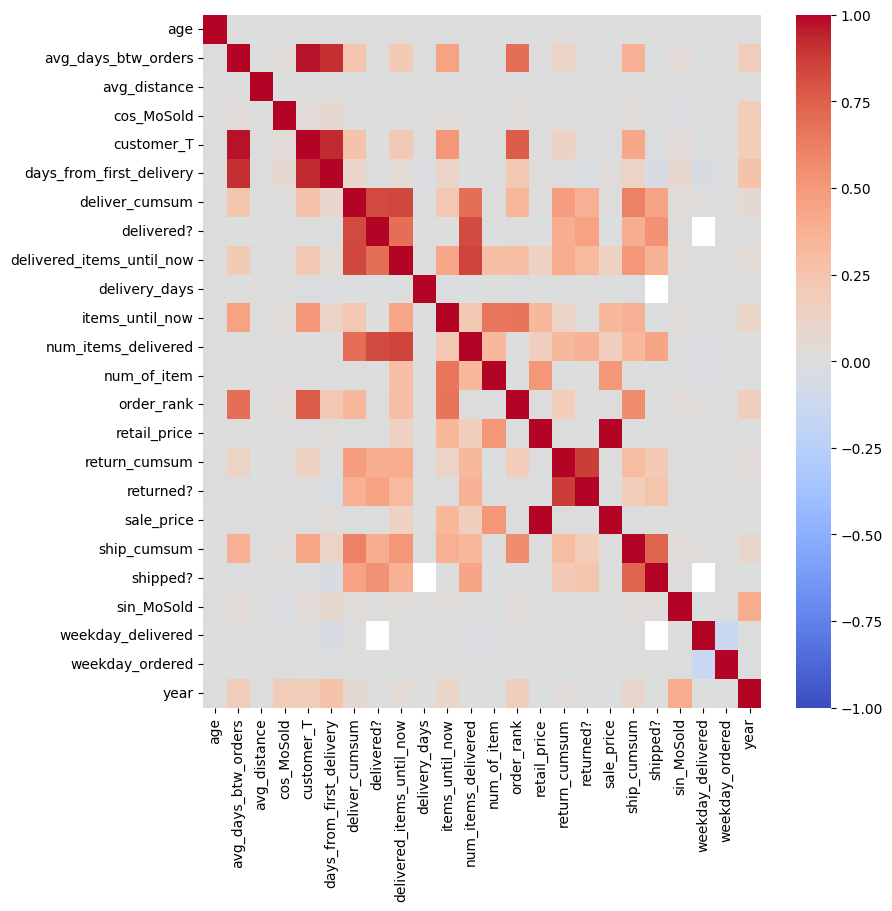

In [361]:
feat_numerical = sorted(X.select_dtypes(include=["int64", "int32","float64"]).columns)

corr_num = X[feat_numerical].corr()

plt.figure(figsize=(9, 9))
sns.heatmap(corr_num, cmap='coolwarm',vmin=-1, vmax=1);

In [50]:
X.shape, y.shape

((125226, 32), (125226,))

In [51]:
X.select_dtypes(include='object').nunique()

status                 5
gender                 2
country               16
traffic_source         5
age_group              6
category_preffered    26
dept_pref              2
browser_pref           5
dtype: int64

## Normalize numeric values and encode categorical values

In [362]:
preproc_numerical_baseline = make_pipeline(
    SimpleImputer(),
    MinMaxScaler()
)

preproc_categorical_baseline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)


preproc_baseline = make_column_transformer(
    (preproc_numerical_baseline, make_column_selector(dtype_include=["int64", "float64", "int32"])),
    (preproc_categorical_baseline, make_column_selector(dtype_include=["object"])),
    remainder="drop"
)

preproc_baseline

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f7df2e68f10>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f7df2e6bee0>)])

In [ ]:
test = preproc_baseline.fit_transform(X)
test.shape

## Model Selection

### Trees

In [363]:
model = GradientBoostingClassifier(n_estimators=100, verbose=0)

pipe_gb = make_pipeline(preproc_baseline, model)
score = cross_val_score(pipe_gb, X, y, cv=5, scoring='accuracy', n_jobs=-1).mean()

score

0.6302474062250599

In [364]:
pipe_randomforest = make_pipeline(preproc_baseline, RandomForestClassifier())
score_randomforest = cross_val_score(pipe_randomforest, X, y, cv=5, scoring='accuracy', n_jobs=-1).mean()
score_randomforest

0.6187283852088321

In [365]:
model = AdaBoostClassifier(n_estimators=100, algorithm='SAMME')

pipe_ada = make_pipeline(preproc_baseline, model)
score = cross_val_score(pipe_ada, X, y, cv=5, scoring='accuracy', n_jobs=-1).mean()

score

0.6291832934291035

In [ ]:
estimators_ = [
    ('gbc', GradientBoostingClassifier()),
    ('rfc', RandomForestClassifier()),
    ('ada', AdaBoostClassifier())
]

model = VotingClassifier(estimators=estimators_)

pipe_vote = make_pipeline(preproc_baseline, model)
score = cross_val_score(pipe_vote, X, y_binary, cv=5, scoring='accuracy', n_jobs=-1).mean()

score

In [ ]:
model = ExtraTreesClassifier()

pipe_ext = make_pipeline(preproc_baseline, model)
score = cross_val_score(pipe_ext, X, y_binary, cv=5, scoring='accuracy', n_jobs=-1).mean()

score

In [ ]:
model = BaggingClassifier()

pipe_bag = make_pipeline(preproc_baseline, model)
score = cross_val_score(pipe_bag, X, y_binary, cv=5, scoring='accuracy').mean()

score

In [ ]:
pipe_tree = make_pipeline(preproc_baseline, DecisionTreeClassifier())
score_tree = cross_val_score(pipe_tree, X, y_binary, cv=5, scoring='accuracy').mean()

score_tree

### Clustering

In [ ]:
pipe_knn = make_pipeline(preproc_baseline, KNeighborsClassifier())
score_knn = cross_val_score(pipe_knn, X, y_binary, cv=5, scoring='accuracy', n_jobs=-1).mean()
score_knn

## 0.587976953150862

### others

In [ ]:
svm_classifier = SVC(kernal='poly', degree=3)

pipe_svc = make_pipeline(preproc_baseline, svm_classifier)

In [ ]:
score_svc = cross_val_score(pipe_svc, X, y_binary, cv=5, scoring='accuracy').mean()
score_svc

## Parameter tuning of the selected model

In [366]:
# Split train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [367]:
X_train_p = preproc_baseline.fit_transform(X_train)

In [368]:
# Define the parameter grid
param_grid = {
    'n_estimators': [150, 200, 300],
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [3, 4, 5]
}

# Instantiate the Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier()

# Instantiate the Grid Search
grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=5, n_jobs=-1) 

# Fit the Grid Search
grid_search.fit(X_train_p, y_train)

# Evaluate Results
print("Best parameters found: ", grid_search.best_params_)
print("Best F1 score found: ", grid_search.best_score_)

# Best parameters found:  {'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 150}
# Best F1 score found:  0.6310520948487887

Best parameters found:  {'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 150}
Best F1 score found:  0.6310520948487887


## Fit, Predict, Evaluate

In [369]:
# Selected model with best parameters

model = GradientBoostingClassifier(n_estimators=150, learning_rate=0.03, max_depth = 5, verbose=0)

In [370]:
pipe_gb = make_pipeline(preproc_baseline, model)
# score = cross_val_score(pipe_gb, X, y_binary, cv=5, scoring='accuracy', n_jobs=-1).mean()

# score

In [371]:
pipe_selected = pipe_gb

In [372]:
pipe_selected.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7df2e68f10>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7df2e6bee0>)])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=5,
                                            n_estimators=150))])

In [373]:
y_pred = pipe_selected.predict(X_test)

In [374]:
(y_pred.sum(), y_test.sum())

(232, 2798)

In [375]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# Assuming y_test contains the actual labels
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.6291566906092045
Precision: 0.521551724137931
Recall: 0.04324517512508935
F1-score: 0.07986798679867987
Confusion Matrix:
 [[4609  111]
 [2677  121]]


## Understanding the model

### Feature importance

In [379]:
# Get Feature importance
model = pipe_selected.named_steps['gradientboostingclassifier']

feature_importance = model.feature_importances_
one_hot_encoder = preproc_baseline.named_transformers_['pipeline-2']['onehotencoder']
encoded_columns = one_hot_encoder.get_feature_names_out()


numerical_columns = preproc_baseline.named_transformers_['pipeline-1']['simpleimputer'].get_feature_names_out()
all_column_names = list(numerical_columns) + list(encoded_columns)

# Ensure that the length of the concatenated list matches the length of the feature_importance array
assert len(all_column_names) == len(feature_importance), "Lengths of column names and feature importance values do not match"

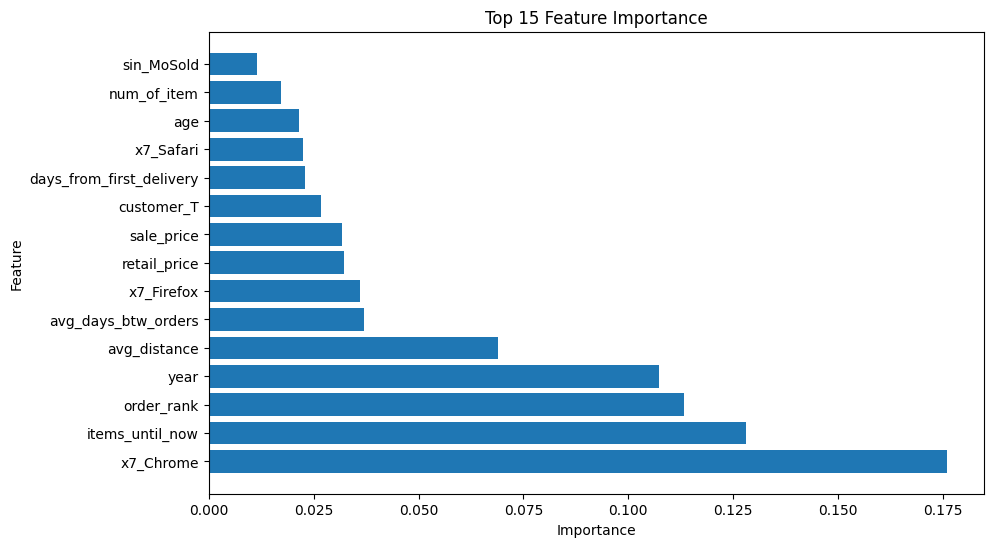

In [380]:
# Pair feature importance scores with corresponding column names
feature_importance_df = pd.DataFrame({'Feature': all_column_names, 'Importance': feature_importance})

# Sort the DataFrame by importance score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:15], feature_importance_df['Importance'][:15])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importance')
plt.show()

### Quick observation of the important feature vs. y

In [201]:
X.columns

Index(['status', 'gender', 'num_of_item', 'order_rank', 'delivery_days',
       'weekday_ordered', 'weekday_delivered', 'returned?', 'shipped?',
       'delivered?', 'return_cumsum', 'ship_cumsum', 'deliver_cumsum',
       'customer_T', 'days_from_first_delivery', 'items_until_now',
       'num_items_delivered', 'delivered_items_until_now', 'age', 'country',
       'traffic_source', 'age_group', 'sale_price', 'retail_price',
       'category_preffered', 'dept_pref', 'browser_pref', 'avg_distance',
       'sale_ratio', 'sin_MoSold', 'cos_MoSold', 'year'],
      dtype='object')

In [413]:
important = input_filtered.copy()

#### YEAR

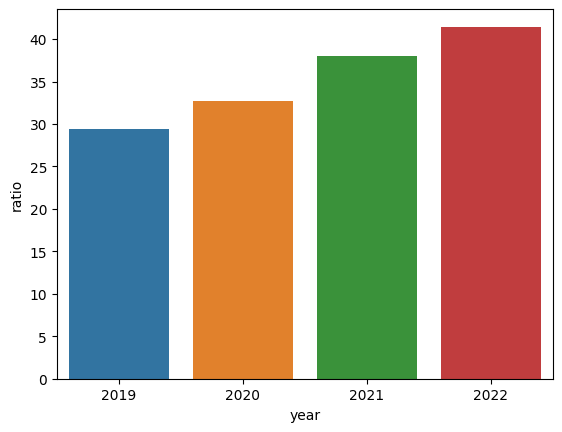

In [426]:
# order happens more in early years
data_year = (important.groupby(by='year')['y'].sum()/important.groupby(by='year')['y'].count()*100).reset_index(name='ratio')

sns.barplot(data=data_year, x='year', y='ratio');

#### order rank

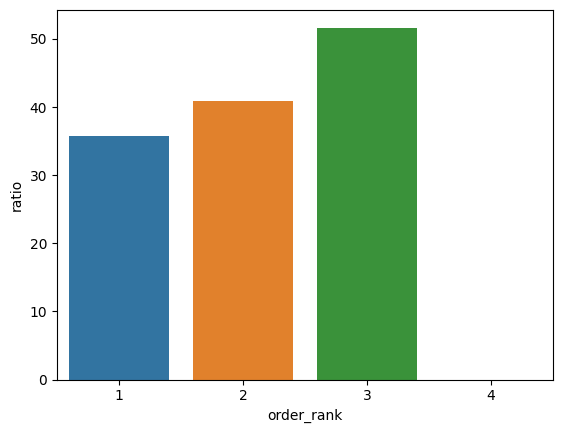

In [394]:
# half of the customers who bought 3rd time will buy another
data_rank = (important.groupby(by='order_rank')['y'].sum()/important.groupby(by='order_rank')['y'].count()*100).reset_index(name='ratio')

sns.barplot(data=data_rank, x='order_rank', y='ratio');

#### items_until_now

''

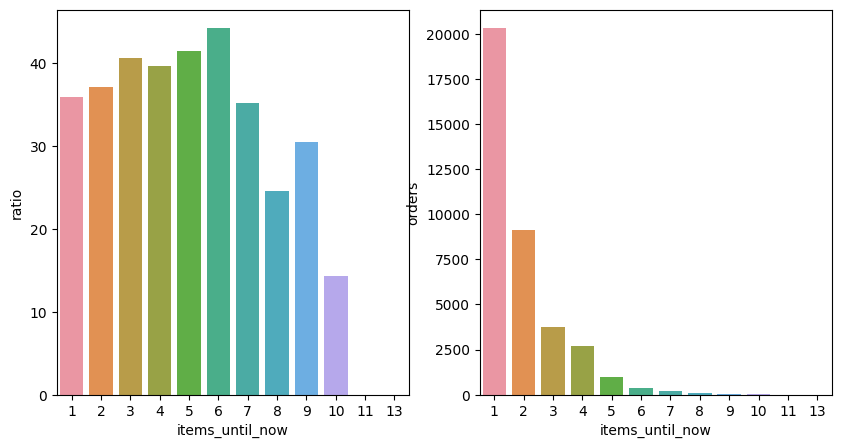

In [420]:
data_items = (important.groupby(by='items_until_now')['y'].sum()/important.groupby(by='items_until_now')['y'].count()*100).reset_index(name='ratio')
data_items_count = important.groupby('items_until_now')['order_id'].nunique().reset_index(name='orders')


fig, axes = plt.subplots(1,2, figsize=(10,5))

sns.barplot(data=data_items, x='items_until_now', y='ratio', ax=axes[0])
sns.barplot(data=data_items_count, x='items_until_now', y='orders', ax=axes[1])

;

#### customer_T

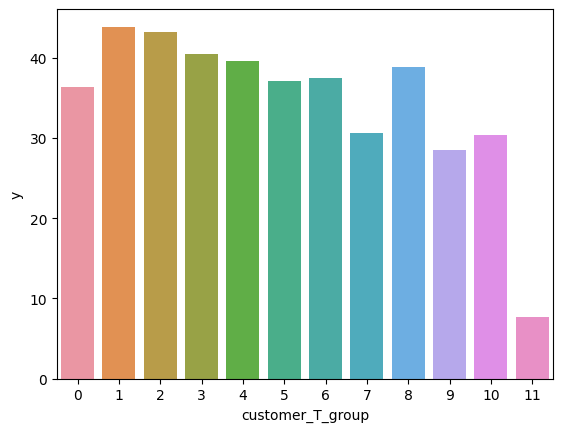

In [395]:
# long customer T increases repeat purchase potential
important['customer_T_group'] = (important['customer_T']/100).astype('int')
data_customer_t = (important.groupby(by='customer_T_group')['y'].sum()/important.groupby(by='customer_T_group')['y'].count()*100).reset_index()

sns.barplot(data=data_customer_t, x='customer_T_group',y='y');

#### Browser

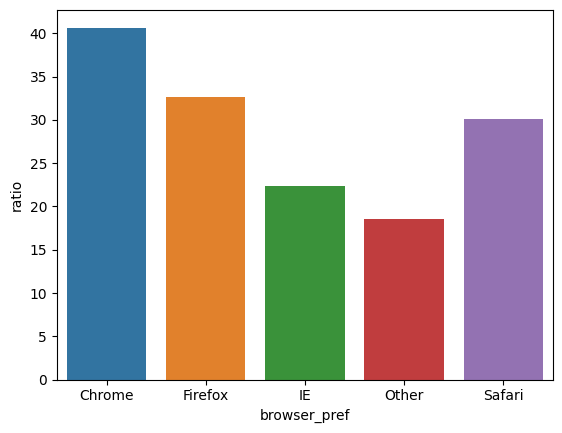

In [396]:
data_browser = (important.groupby(by='browser_pref')['y'].sum()/important.groupby(by='browser_pref')['y'].count()*100).reset_index(name='ratio')

sns.barplot(data=data_browser, x='browser_pref', y='ratio');

#### avg_distance

AttributeError: 'Axes' object has no attribute 'plt'

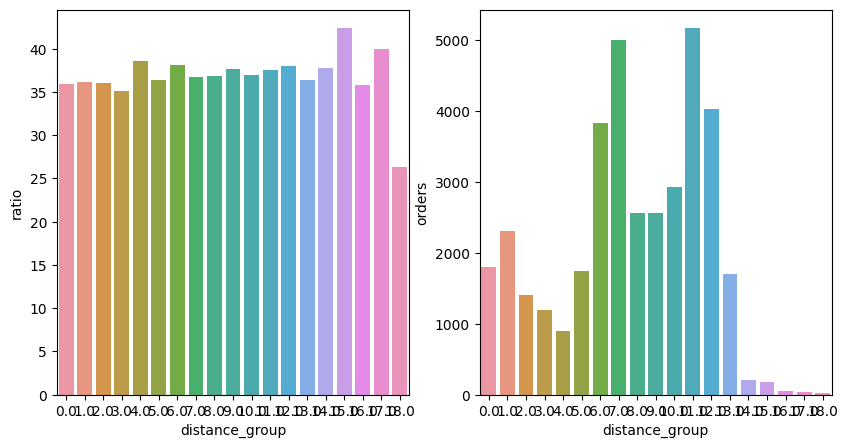

In [425]:
important['distance_group'] = important.avg_distance//1000
data_distance = (important.groupby(by='distance_group')['y'].sum()/important.groupby(by='distance_group')['y'].count()*100).reset_index(name='ratio')
data_distance_count = important.groupby('distance_group')['order_id'].nunique().reset_index(name='orders')


fig, axes = plt.subplots(1,2, figsize=(10,5))

sns.barplot(data=data_distance, x='distance_group', y='ratio', ax=axes[0])
sns.barplot(data=data_distance_count, x='distance_group', y='orders', ax=axes[1])


plt.xticks(rotation=90)
;

#### Sale price

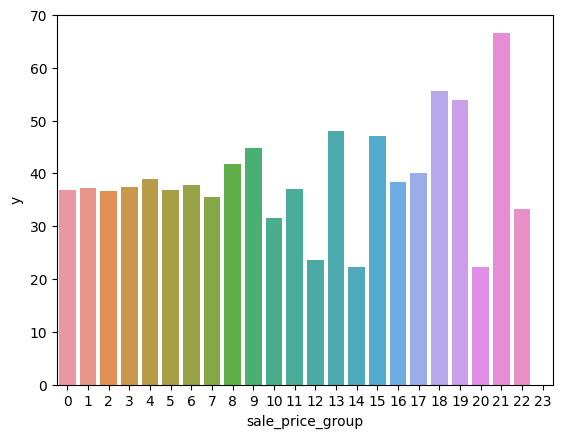

In [415]:
# long customer T increases repeat purchase potential
important['sale_price_group'] = (important['sale_price']/50).astype('int')
data_sale_price = (important.groupby(by='sale_price_group')['y'].sum()/important.groupby(by='sale_price_group')['y'].count()*100).reset_index()
data_sale_price.counts = 


sns.barplot(data=data_customer_t, x='sale_price_group',y='y');

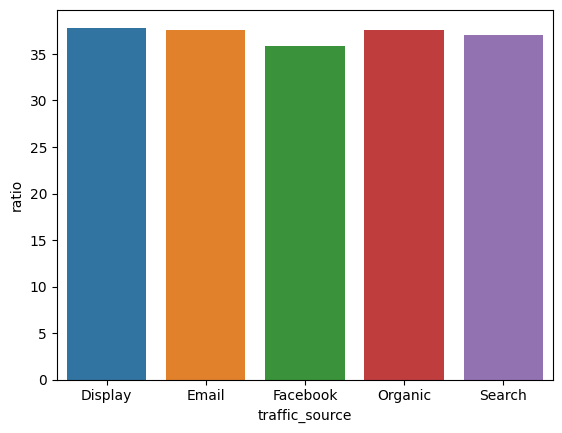

In [397]:
data_source = (important.groupby(by='traffic_source')['y'].sum()/important.groupby(by='traffic_source')['y'].count()*100).reset_index(name='ratio')

sns.barplot(data=data_source, x='traffic_source', y='ratio');

### Partial Dependence Plots

In [227]:
# import pdpbox.pdp as pdp

In [228]:
# features = [0, 1, (0, 1)]
# PartialDependenceDisplay.from_estimator(clf, X, features)

In [229]:
# PartialDependenceDisplay.from_estimator(model, X, features)

In [129]:
X.shape

(12000, 10)

In [130]:
y.shape

(12000,)

In [131]:
y

array([ 1., -1.,  1., ..., -1., -1.,  1.])

## Save model

In [ ]:
import pickle
import joblib

In [ ]:
# # Define the filename for your .pkl file
# filename = '../clv_the_look/training/rf_model_v1.pkl'

# # Save the trained model to a .pkl file
# with open(filename, 'wb') as file:
#     pickle.dump(pipe_randomforest, file)

In [ ]:
filename = '../clv_the_look/training/gb_model_v1.pkl'

# Save the trained model to a .pkl file
with open(filename, 'wb') as file:
    joblib.dump(pipe_selected, filename)

In [ ]:
## input csv

X_test.to_csv('../clv_the_look/training/input_X_test.csv', index=False, encoding='utf-8')

X_test

# Customer Segmentation

In [ ]:
def rfm_calculation(order_item_df)

In [263]:
top_users = \
orders_df.groupby('user_id')['created_at'].nunique().reset_index(name='orders').sort_values(by='orders', ascending=False).\
head(2)['user_id'].tolist()

In [261]:
events_df.columns

Index(['id', 'user_id', 'sequence_number', 'session_id', 'created_at',
       'ip_address', 'city', 'state', 'postal_code', 'browser',
       'traffic_source', 'uri', 'event_type'],
      dtype='object')

In [268]:
orders_df[orders_df['user_id']==13371].merge(events_df, on='user_id', how='left')[['order_id','status','created_at_x',
                                                                                           'id', 'event_type','created_at_y'
                                                                                           ]].sort_values(by=['created_at_y'])

,order_id,status,created_at_x,id,event_type,created_at_y
18,16759,Complete,2021-12-25 09:50:00,173247,home,2021-12-25 07:23:23
105,16761,Shipped,2023-02-17 09:50:00,173247,home,2021-12-25 07:23:23
76,16762,Processing,2022-05-07 09:50:00,173247,home,2021-12-25 07:23:23
47,16760,Complete,2023-08-12 09:50:00,173247,home,2021-12-25 07:23:23
37,16760,Complete,2023-08-12 09:50:00,173248,department,2021-12-25 07:24:20
...,...,...,...,...,...,...
115,16761,Shipped,2023-02-17 09:50:00,173265,purchase,2023-08-13 06:10:49
68,16762,Processing,2022-05-07 09:50:00,173258,purchase,2023-08-16 09:04:17
39,16760,Complete,2023-08-12 09:50:00,173258,purchase,2023-08-16 09:04:17
10,16759,Complete,2021-12-25 09:50:00,173258,purchase,2023-08-16 09:04:17


In [243]:
test_country_event = events_df.groupby(by='user_id')['traffic_source'].nunique().reset_index()

In [244]:
event_types_list = ['product','cart','department','purchase','cancel','home']

for idx, type in enumerate(event_types_list):
    print(idx, type)

0 product
1 cart
2 department
3 purchase
4 cancel
5 home


In [247]:
def cluster_event_df(events_df):
    '''
    Returns most used browser per user_id
    '''
    
    events_df = dtype_cast_datetime(events_df)
    
    events_df = events_df[events_df['user_id'].notna()].copy()

    # base
    base = events_df.groupby('user_id')['session_id'].nunique().reset_index(name='sessions')
    
    # Preffered browser
    count_browser = events_df.groupby(['user_id', 'browser']).size().reset_index(name='count')
    max_count_index = count_browser.groupby('user_id')['count'].idxmax()
    preferred_browser = count_browser.loc[max_count_index]
    pref_brsr_no_duplicates = preferred_browser.drop_duplicates(subset=['user_id']).rename(columns={'browser':'browser_pref'})
    base = base.merge(pref_brsr_no_duplicates[['user_id','browser_pref']],on='user_id',how='left')

    # types of events
    event_types_list = ['product','cart','department','purchase','cancel','home']
    
    for type in event_types_list:
        column_ = type + '_counts'
        user_behaviour = events_df[events_df['event_type']==type].groupby(by='user_id')['session_id'].nunique().reset_index(name=column_)
        base = base.merge(user_behaviour, on='user_id', how='left')
    
    
    return base

In [248]:
cluster_event_df(events_df)

,user_id,sessions,browser_pref,product_counts,cart_counts,department_counts,purchase_counts,cancel_counts,home_counts
0,1.0,3,Chrome,3,3,3,3,NaN,NaN
1,2.0,1,Firefox,1,1,1,1,NaN,1.0
2,3.0,5,Firefox,5,5,5,5,NaN,3.0
3,4.0,1,Chrome,1,1,1,1,NaN,1.0
4,5.0,3,Chrome,3,3,3,3,NaN,NaN
...,...,...,...,...,...,...,...,...,...
80039,99993.0,1,Firefox,1,1,1,1,NaN,1.0
80040,99996.0,4,Chrome,4,4,4,4,NaN,NaN
80041,99998.0,3,Chrome,3,3,3,3,NaN,3.0
80042,99999.0,2,Chrome,2,2,2,2,NaN,NaN


In [ ]:
def cluser_item_product_agg(item_product_df):
    '''
    to user level
    '''

    base = item_level_df[['user_id','order_item_id']].groupby('user_id').count().fillna(0).rename(columns={'order_item_id':'num_order_items'}).reset_index()
    
    # order revenue
    revenue = item_level_df.groupby(by='user_id')['sale_price'].sum().reset_index(name='total_sales')
    base = base.merge(revenue, on='user_id', how='left') 
    
    # order retail_price
    retail_price = item_level_df.groupby(by='user_id')['retail_price'].sum().reset_index(name='total_retail_price')
    base = base.merge(retail_price, on='user_id', how='left') 

    # total_orders
    total_orders = item_level_df.groupby(by='user_id')['order_id'].nunique().reset_index(name='total_orders')
    base = base.merge(total_orders, on='user_id', how='left')

    # total_brands
    total_brands = item_level_df.groupby(by='user_id')['brand'].nunique().reset_index(name='total_num_brands')
    base = base.merge(total_brands, on='user_id', how='left')

    # firt order created at year, month
    year = item_level_df.groupby(by='user_id')['created_at'].min().reset_index(name='min_order_created_at')
    year['min_order_created_year'] = year.min_order_created_at.dt.year
    year['min_order_created_month'] = year.min_order_created_at.dt.month
    base = base.merge(year, on='user_id', how='left')

    base['abv'] = base.total_sales / base.total_orders

    # total_period
    max_date = item_level_df['created_at'].max()
    base['customer_T'] = (max_date - base['min_order_created_at']).dt.days
    
    
    
    # Most frequent category
    count_cat = item_level_df.groupby(['user_id', 'category']).size().reset_index(name='count')
    # Find the index of the row with the maximum count for each user
    max_count_index = count_cat.groupby('user_id')['count'].idxmax()
    # Extract the rows corresponding to the maximum counts
    preferred_categories = count_cat.loc[max_count_index]
    # remove duplicates
    pref_cat_no_duplicates = preferred_categories.drop_duplicates(subset=['user_id']).rename(columns={'category':'category_preffered'})

    base = base.merge(pref_cat_no_duplicates[['user_id','category_preffered']],on='user_id',how='left')            


    # Department
    # Most frequent category
    count_dept = item_level_df.groupby(['user_id', 'department']).size().reset_index(name='count')
    # Find the index of the row with the maximum count for each user
    max_count_index_dept = count_dept.groupby('user_id')['count'].idxmax()
    # Extract the rows corresponding to the maximum counts
    preferred_dept = count_dept.loc[max_count_index_dept]
    # remove duplicates
    pref_dept_no_duplicates = preferred_dept.drop_duplicates(subset=['user_id']).rename(columns={'department':'dept_pref'})

    base = base.merge(pref_dept_no_duplicates[['user_id','dept_pref']],on='user_id',how='left')    
    
    return base

In [ ]:
item_product_df = join_tables_item_level(order_items_df, products_df)

In [ ]:
test = cluser_item_product_agg(item_product_df)

## Data Prep for Clustering

In [ ]:
user_prep = select_user_columns(users_df)
event_prep = cluster_event_df(events_df)
item_product_df = join_tables_item_level(order_items_df, products_df)
order_prep = cluser_item_product_agg(item_product_df)

In [ ]:
## Join all of them

input_prep = user_prep.copy()
input_prep = input_prep.merge(event_prep, on='user_id', how='left')
input_prep = input_prep.merge(order_prep, on='user_id', how='left')

columns_excl = ['user_id','user_created_at','min_order_created_at','min_order_created_at']

input_prep = input_prep.drop(columns=columns_excl)
input_prep.info()

In [ ]:
input_prep.isna().sum()

In [ ]:
input_prep['total_orders'].value_counts()

## preprocessing, fit, predict

In [ ]:
km_input = preproc_baseline.fit_transform(input_prep)

In [ ]:
prepped_values = pd.DataFrame(km_input.toarray())

In [ ]:
sns.heatmap(prepped_values.corr(), cmap='coolwarm')

In [ ]:
km_input.shape

In [ ]:
km = KMeans(n_clusters=4)
km.fit(km_input)

In [ ]:
cluster_labels= km.predict(km_input)
cluster_labels

In [ ]:
centroids = km.cluster_centers_
centroids.shape

In [ ]:
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_counts = dict(zip(unique, counts))
print(cluster_counts)

## Trying DeepLearning

In [72]:
''' Imbalanced Classes'''
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

''' Tensorflow Keras'''
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Normalization
from tensorflow.keras.metrics import Recall, Precision


2024-03-12 09:16:43.753151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 09:16:43.931414: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-12 09:16:43.980092: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-12 09:16:43.980113: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

In [ ]:
X.head()

In [73]:
# Preprocess
X_t = preproc_baseline.fit_transform(X)

In [ ]:
X_t.toarray()

In [74]:
# Train test split before any resampling to keep real test set
X_train, X_test, y_train, y_test = train_test_split(X_t, y_binary, test_size = 0.3)

In [75]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3)

In [76]:
X_train = X_train.toarray()
X_val = X_val.toarray()

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

In [77]:
# How many "fraud" samples do I have in each split?
print(np.sum(y_train[y_train == 1]))
print(np.sum(y_val[y_val == 1]))
print(np.sum(y_test[y_test == 1]))

print("-"*100)

print(f"There are {pd.Series(y_train).value_counts()[1]} purchased users in the train set")
print(f"There are {pd.Series(y_val).value_counts()[1]} purchased users in the val set")
print(f"There are {pd.Series(y_test).value_counts()[1]} purchased users in the test set")

22145
9517
13520
----------------------------------------------------------------------------------------------------
There are 22145 purchased users in the train set
There are 9517 purchased users in the val set
There are 13520 purchased users in the test set


In [78]:
print(X_train.shape)
print(X_val.shape)

(61360, 91)
(26298, 91)


## Neural Network Iteration

In [79]:
metrics = [
    keras.metrics.Recall(name='recall'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]

2024-03-12 09:17:19.640786: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-03-12 09:17:19.641090: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-03-12 09:17:19.641121: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (JM-GALAXY-PRO): /proc/driver/nvidia/version does not exist
2024-03-12 09:17:19.641657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [80]:
X_train.shape

(61360, 91)

In [81]:
def init_model():
    input_shape = X_train.shape[1:]
    # normalizer = Normalization()
    # normalizer.adapt(X_train)
    
    model = models.Sequential()
    # model.add()
    model.add(layers.Dense(64, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    # Model compilation
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=metrics)
    return model

## Regularized model

In [ ]:
[X_train.shape, y_train.shape]

In [ ]:
[X_val.shape, y_val.shape]

In [83]:
model = init_model()

es = EarlyStopping(
    patience=10,
    monitor='val_recall', 
    restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=4,
                    callbacks=[es], shuffle=True)

Epoch 1/100
15340/15340 [==============================] - 23s 1ms/step - loss: 0.6591 - recall: 0.0332 - precision: 0.4916 - prc: 0.4037 - val_loss: 0.6507 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_prc: 0.4347
Epoch 2/100
15340/15340 [==============================] - 19s 1ms/step - loss: 0.6491 - recall: 0.0000e+00 - precision: 0.0000e+00 - prc: 0.3972 - val_loss: 0.6424 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_prc: 0.4580
Epoch 3/100
15340/15340 [==============================] - 19s 1ms/step - loss: 0.6429 - recall: 0.0000e+00 - precision: 0.0000e+00 - prc: 0.4214 - val_loss: 0.6386 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_prc: 0.4759
Epoch 4/100
15340/15340 [==============================] - 20s 1ms/step - loss: 0.6388 - recall: 0.0000e+00 - precision: 0.0000e+00 - prc: 0.4446 - val_loss: 0.6313 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_prc: 0.4834
Epoch 5/100
15340/15340 [==============================] - 20s 1

In [84]:
def plot_loss_precision_recall_curve(history):
    
    fig, ax =plt.subplots(1,3,figsize=(20,5))
    
    # --- LOSS
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- RECALL

    ax[1].plot(history.history['recall'])
    ax[1].plot(history.history['val_recall'])
    ax[1].set_title('Model recall', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right') 
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    
    # --- PRECISION
    
    
    ax[2].plot(history.history['precision'])
    ax[2].plot(history.history['val_precision'])
    ax[2].set_title('Model precision', fontsize = 18)
    ax[2].set_xlabel('Epoch', fontsize = 14)
    ax[2].set_ylabel('Precision', fontsize = 14)
    ax[2].legend(['Train', 'Val'], loc='lower right')  
    ax[2].grid(axis="x",linewidth=0.5)
    ax[2].grid(axis="y",linewidth=0.5)    
    
    plt.show()

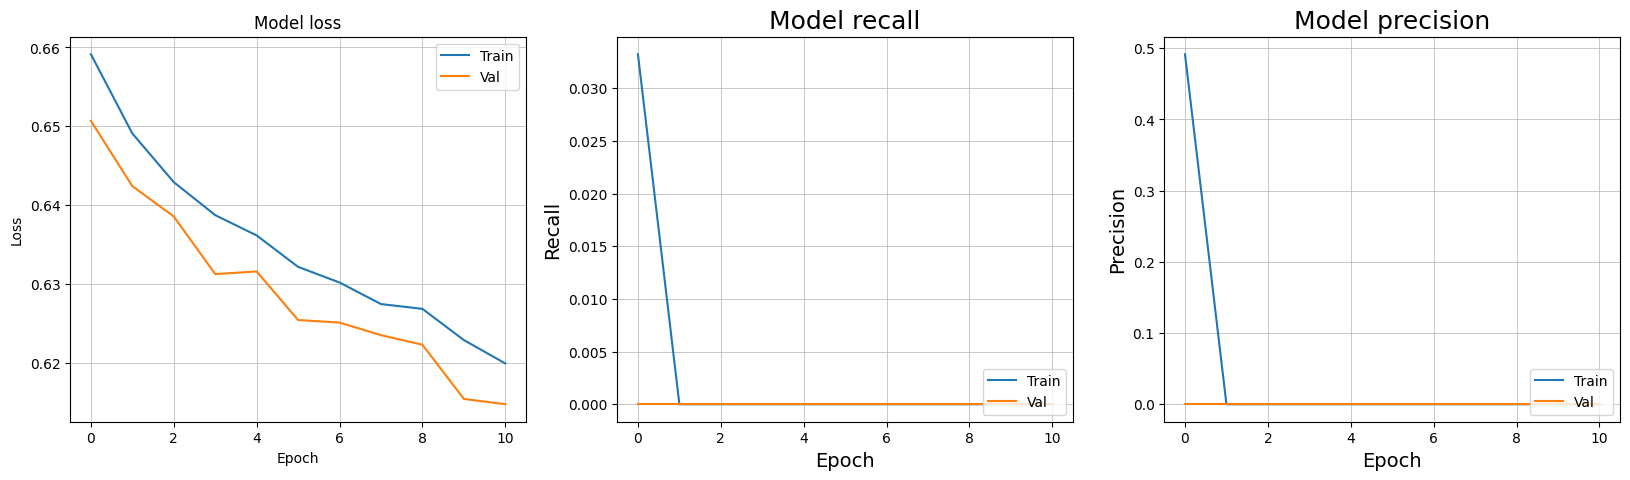

In [85]:
plot_loss_precision_recall_curve(history)

## Score it

In [86]:
model.evaluate(X_test, y_test, verbose=0, return_dict=True)

{'loss': 0.6497561931610107,
 'recall': 0.0,
 'precision': 0.0,
 'prc': 0.43141239881515503}

In [87]:
y_pred_proba = model.predict(X_test)

1174/1174 [==============================] - 1s 577us/step


In [88]:
threshold = 0.50 # 50% 

y_pred_binary = np.where(y_pred_proba > threshold, 1, 0 )

## Confusion Matrix

In [89]:
# Confusion Matrix
cm = confusion_matrix(y_test,y_pred_binary)
cm

array([[24048,     0],
       [13520,     0]])

Text(0.5, 25.722222222222214, 'Predicted label')

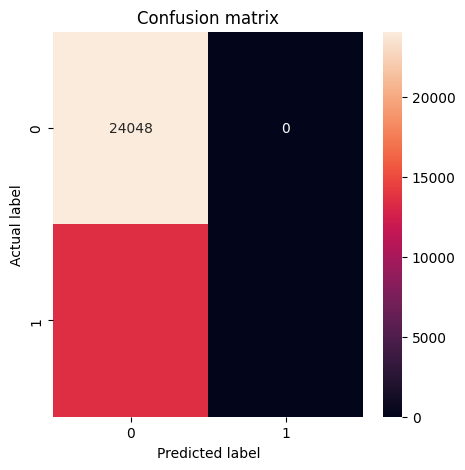

In [90]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_binary))

In [ ]:
from sklearn.metrics import precision_recall_curve

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)
    plt.plot(recall, precision, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [ ]:
plot_prc("Test", y_test, y_pred_proba, linestyle='--')
plt.legend(loc='lower right')